# Dynamics of ARC dataset

In [1]:
import sys

sys.path.append("/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm")

## Setup

In [2]:
from grokking_llm.utils import (
    DeploymentCfg,
    TrainingCfg,
    get_p_smi_containers,
    get_pointwise_container,
    get_pointwise_layerwise_container,
)
from grokking_llm.measures_dyn import (
    SampleLossMetrics,
    MemoMembershipMetrics,
    MahalanobisMetrics,
    PSmiMetrics,
    PerfMetrics,
    GeneralMetrics,
    PSmiSlopeMetrics,
    PSmiStdMetrics,
)
from grokking_llm.training import (
    get_dataset,
    format_dataset,
    add_labels,
    get_random_split,
)

2024-09-13 14:36:24.366 | INFO     | grokking_llm.utils.logs:<module>:20 - Welcome to `grokking_llm` module!
2024-09-13 14:36:24.371 | INFO     | grokking_llm.utils.env_vars:<module>:15 - Found an environment var config at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/env_vars.cfg, exporting its variables.
2024-09-13 14:36:24.374 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var OMP_NUM_THREADS=2
2024-09-13 14:36:24.375 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var GROKKING_PATH_REPLACE_FROM=/lustre/fswork/projects/rech/yfw/upp42qa/
2024-09-13 14:36:24.376 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var GROKKING_PATH_REPLACE_TO=/Users/jeremie/Documents/01-Travail/01-Doctorat/
2024-09-13 14:36:24.379 | DEBUG    | grokking_llm.utils.hf_hub:<module>:32 - Setting env variable HF_HOME=/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/.cache/huggingface
2024-09-13 14:36:24.380 | INFO 

In [3]:
import collections
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, r2_score
import pandas as pd
from scipy.stats import spearmanr, rankdata
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from tqdm import tqdm

## Loading

In [4]:
STEP_PER_EPOCH = 3750

In [5]:
cfg = TrainingCfg.autoconfig("0K1p")
dep_cfg = DeploymentCfg.autoconfig("ZfTT")
checkpoints = [k*STEP_PER_EPOCH/5 for k in range(0,6)] + [k*STEP_PER_EPOCH for k in range(2,11)]

2024-09-13 14:36:34.126 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: 0K1p is the prefix of confi_id 0K1pZkoAv45RZXOIJl9kFw in `paths.individual_outputs`, building from it.
2024-09-13 14:36:34.131 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-13 14:36:34.133 | WARNING  | grokking_llm.utils.training_cfg:__init__:735 - You selected `cuda` accelerator, but it is not available. CPU will be used instead.
2024-09-13 14:36:34.143 | INFO     | grokking_llm.utils.training_cfg:autoconfig:355 - Autoconfig `name`: /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/deployment/ZfTT7SCYBAzBtjT3_sy3wg/base_training_cfg.json is a valid path, building from it.
2024-09-13 14:36:34.145 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. Th

In [6]:
train_ds = get_dataset(cfg, split="train")
train_ds = format_dataset(train_ds, cfg)
train_ds = add_labels(train_ds, cfg, split="train")
train_ds = get_random_split(train_ds, cfg)
global_idx = train_ds["global_index"]

print(f"{len(global_idx)} elements")

2024-09-13 14:36:52.258 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-13 14:36:52.260 | INFO     | grokking_llm.training.datasets:format_dataset:174 - Formatting dataset cais/mmlu
2024-09-13 14:36:52.262 | DEBUG    | grokking_llm.training.datasets:format_dataset:175 - Using seed=0 and force_template=False for formatting.
Map: 100%|██████████| 30000/30000 [00:06<00:00, 4784.90 examples/s]
2024-09-13 14:36:58.545 | INFO     | grokking_llm.training.datasets:add_labels:233 - Adding labels to dataset cais/mmlu
2024-09-13 14:36:58.547 | DEBUG    | grokking_llm.training.datasets:add_labels:234 - Using proportion label_noise=0.03334 with seed=0
Map: 100%|██████████| 30000/30000 [00:03<00:00, 7952.92 examples/s]
2024-09-13 14:37:02.338 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-13 14:37:02.339 | DEBUG    | grokking_llm.training.datasets:get_random_split:278

15000 elements


## Containers

In [7]:
def sanityze(memo_per_chk_per_idx):

    num_changed = 0

    for chk in memo_per_chk_per_idx:
        for idx in memo_per_chk_per_idx[chk]:
            old_val = memo_per_chk_per_idx[chk][idx]
            memo_per_chk_per_idx[chk][idx] = max(-100.0, memo_per_chk_per_idx[chk][idx])
            memo_per_chk_per_idx[chk][idx] = min(100.0, memo_per_chk_per_idx[chk][idx])
            
            if old_val != memo_per_chk_per_idx[chk][idx]:
                num_changed += 1

    print(f"Num item changed: {num_changed}")

In [8]:
memo = MemoMembershipMetrics(cfg, dep_cfg)
memo_df = memo.load_metrics_df()
memo_per_chk_per_idx = get_pointwise_container(memo_df, memo.column_offset)
sanityze(memo_per_chk_per_idx)

2024-09-13 14:37:02.446 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__init__:48 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-13 14:37:08.065 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-13 14:37:08.075 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-13 14:37:08.076 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-13 14:37:08.149 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_ZfTT7SCYBAzBtjT3_sy3wg` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-13 14:37:08.155 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output

Num item changed: 193


In [9]:
p_smi = PSmiMetrics(cfg)
p_smi_df = p_smi.load_metrics_df()
p_smi_per_chk_per_layer_per_idx = get_p_smi_containers(p_smi_df)[0]

2024-09-13 14:37:15.655 | INFO     | grokking_llm.measures_dyn.p_smi_metrics:__init__:37 - Initializing a PSmiMetrics with 2000 estimators, and full_dataset=False.
2024-09-13 14:37:15.658 | DEBUG    | grokking_llm.measures_dyn.p_smi_metrics:__init__:43 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-13 14:37:20.625 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-13 14:37:20.636 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-13 14:37:20.637 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-13 14:37:20.722 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `p_smi_metrics` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-13 14:37:20.725 | DEBUG    | grokking_llm.measures_dyn.dyn

In [10]:
loss = SampleLossMetrics(cfg)
loss_df = loss.load_metrics_df()
loss_per_chk_per_idx = get_pointwise_container(loss_df, loss.column_offset)

2024-09-13 14:52:51.496 | DEBUG    | grokking_llm.measures_dyn.sample_loss_metrics:__init__:23 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-13 14:52:54.934 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-13 14:52:54.945 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-13 14:52:54.946 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-13 14:52:55.022 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `sample_loss` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-13 14:52:55.030 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/0K1pZkoAv45RZXOIJl

In [11]:
general_df = GeneralMetrics(cfg).load_metrics_df()
perf = PerfMetrics(cfg)
perf_df = perf.load_metrics_df().merge(general_df[["checkpoint", "epoch"]], on="checkpoint", how="left")

2024-09-13 14:53:00.793 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `general` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-13 14:53:00.798 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/0K1pZkoAv45RZXOIJl9kFw/metrics/general.csv
2024-09-13 14:53:04.173 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-13 14:53:04.183 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-13 14:53:04.184 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-13 14:53:04.191 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `perf_met

## Plotting dynamics

In [12]:
LAYER = 20
PSMI_THD = -0.1266
PRED_IDX = 1

In [13]:
easy_samples = [idx for idx in global_idx if p_smi_per_chk_per_layer_per_idx[checkpoints[PRED_IDX]][LAYER][idx] > PSMI_THD]
hard_samples = [idx for idx in global_idx if p_smi_per_chk_per_layer_per_idx[checkpoints[PRED_IDX]][LAYER][idx] <= PSMI_THD]

In [14]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

Easy low loss epoch = 0.4
Min test loss = 1.0
Max test acc = 5.0


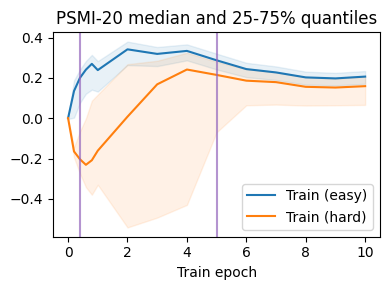

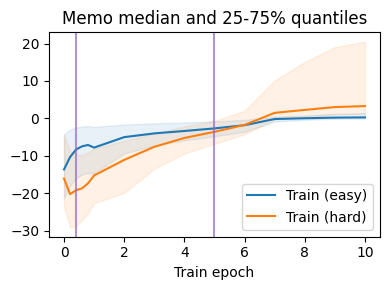

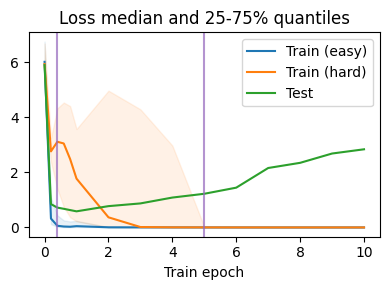

In [20]:
n_cols = 1
n_rows = 1

fig_psmi, ax_psmi = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig_memo, ax_memo = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig_loss, ax_loss = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

all_losses_per_chk = collections.defaultdict(list)

for idx_container, (samples, title) in enumerate(zip([easy_samples, hard_samples], ["Train (easy)", "Train (hard)"])):

    # Values
    epochs = []
    psmi_mean = []
    psmi_q25 = []
    psmi_q75 = []
    memo_mean = []
    memo_q25 = []
    memo_q75 = []
    loss_mean = []
    loss_q25 = []
    loss_q75 = []

    for chk in checkpoints:
        
        # Epoch
        epochs.append(chk / STEP_PER_EPOCH)

        # PSMI
        psmi = [p_smi_per_chk_per_layer_per_idx[chk][LAYER][idx] for idx in samples]
        psmi_mean.append(np.median(psmi))
        psmi_q25.append(np.quantile(psmi, q=0.25))
        psmi_q75.append(np.quantile(psmi, q=0.75))

        # Memo
        memo = [memo_per_chk_per_idx[chk][idx] for idx in samples]
        memo_mean.append(np.median(memo))
        memo_q25.append(np.quantile(memo, q=0.25))
        memo_q75.append(np.quantile(memo, q=0.75))

        # Loss
        loss = [loss_per_chk_per_idx[chk][idx] for idx in samples]
        loss_mean.append(np.median(loss))
        loss_q25.append(np.quantile(loss, q=0.25))
        loss_q75.append(np.quantile(loss, q=0.75))

        # All losses
        all_losses_per_chk[chk].extend(loss)

    # Plotting
    ax_psmi.plot(epochs, psmi_mean, color=COLORS[idx_container], label=title)
    ax_psmi.fill_between(epochs, psmi_q25, psmi_q75, alpha=.1, color=COLORS[idx_container])

    ax_memo.plot(epochs, memo_mean, color=COLORS[idx_container], label=title)
    ax_memo.fill_between(epochs, memo_q25, memo_q75, alpha=.1, color=COLORS[idx_container])

    ax_loss.plot(epochs, loss_mean, color=COLORS[idx_container], label=title)
    ax_loss.fill_between(epochs, loss_q25, loss_q75, alpha=.1, color=COLORS[idx_container])

# Test loss
ax_loss.plot(perf_df["epoch"], perf_df["test_loss_asw"], label="Test", color=COLORS[2])

# Low test loss ?
all_losses_median = [np.quantile(all_losses_per_chk[chk], q=0.5) for chk in sorted(all_losses_per_chk)]
for low_loss_idx, val in enumerate(all_losses_median):
    if low_loss_idx == 0:
        continue
    if val < 0.05*all_losses_median[0]:
        break

# V lines
idx_min_test_loss = np.argmin(perf_df["test_loss_asw"])
idx_max_acc_loss = np.argmax(perf_df["test_accuracy"])
for ax in [ax_loss, ax_memo, ax_psmi]:
    ax.axvline(checkpoints[low_loss_idx]/STEP_PER_EPOCH, color=COLORS[4], linestyle="-", alpha=.7)
    ax.axvline(perf_df["epoch"][idx_max_acc_loss], color=COLORS[4], linestyle="-", alpha=.7)
    if ax == ax_memo:
        ax.legend(loc=4)
    else:
        ax.legend()
    
ax_psmi.set_title(f"PSMI-{LAYER} median and 25-75% quantiles")
ax_memo.set_title("Memo median and 25-75% quantiles")
ax_loss.set_title("Loss median and 25-75% quantiles")

ax_psmi.set_xlabel("Train epoch")
ax_memo.set_xlabel("Train epoch")
ax_loss.set_xlabel("Train epoch")

print(f"Easy low loss epoch = {checkpoints[low_loss_idx]/STEP_PER_EPOCH}")
print(f"Min test loss = {perf_df['epoch'][idx_min_test_loss]}")
print(f"Max test acc = {perf_df['epoch'][idx_max_acc_loss]}")

# FIgures
fig_psmi.tight_layout()
fig_psmi.savefig("dynamics_psmi.pdf")

fig_memo.tight_layout()
fig_memo.savefig("dynamics_memo.pdf")


fig_loss.tight_layout()
fig_loss.savefig("dynamics_loss.pdf")